In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
# Charger les données
listings = pd.read_csv('/Users/mathisgorvien/DEV/datathon-2024/Data/raw/airbnb-lyon-december-2023/listings_detailed.csv')

# Fonction pour calculer la distance Haversine
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcule la distance entre deux points géographiques (en km).
    """
    R = 6371  # Rayon moyen de la Terre en kilomètres
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Différence des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Formule de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Exemple : Calculer la distance entre deux logements
lat1, lon1 = listings.loc[0, ['latitude', 'longitude']]
lat2, lon2 = listings.loc[1, ['latitude', 'longitude']]

distance = haversine(lat1, lon1, lat2, lon2)
print(f"Distance entre les deux logements : {distance:.2f} km")

# Appliquer sur tout le DataFrame
# Exemple pour calculer les distances à partir d'un point de référence
reference_lat, reference_lon = 45.764043, 4.835659  # Exemple : coordonnées de Lyon
listings['distance_from_reference'] = listings.apply(
    lambda row: haversine(reference_lat, reference_lon, row['latitude'], row['longitude']), axis=1
)

# Afficher les distances
print(listings[['id', 'name', 'latitude', 'longitude', 'distance_from_reference']].head())

Distance entre les deux logements : 2.84 km
         id                                               name  latitude  \
0  13652635  Rental unit in Lyon · 1 bedroom · 3 beds · 1 bath  45.77672   
1  42535147  Rental unit in Lyon · 1 bedroom · 1 bed · 1 sh...  45.76600   
2  43736244  Rental unit in Lyon · 1 bedroom · 2 beds · 1 bath  45.76078   
3  30554074  Rental unit in Lyon · ★4.83 · 1 bedroom · 2 be...  45.74628   
4   9474252  Rental unit in Lyon · 2 bedrooms · 2 beds · 1 ...  45.76295   

   longitude  distance_from_reference  
0    4.80419                 2.818614  
1    4.83746                 0.258593  
2    4.87102                 2.766968  
3    4.83717                 1.978631  
4    4.84166                 0.481113  


,Profile Category,Count,Avg Price,Median Price,Avg Distance from Center


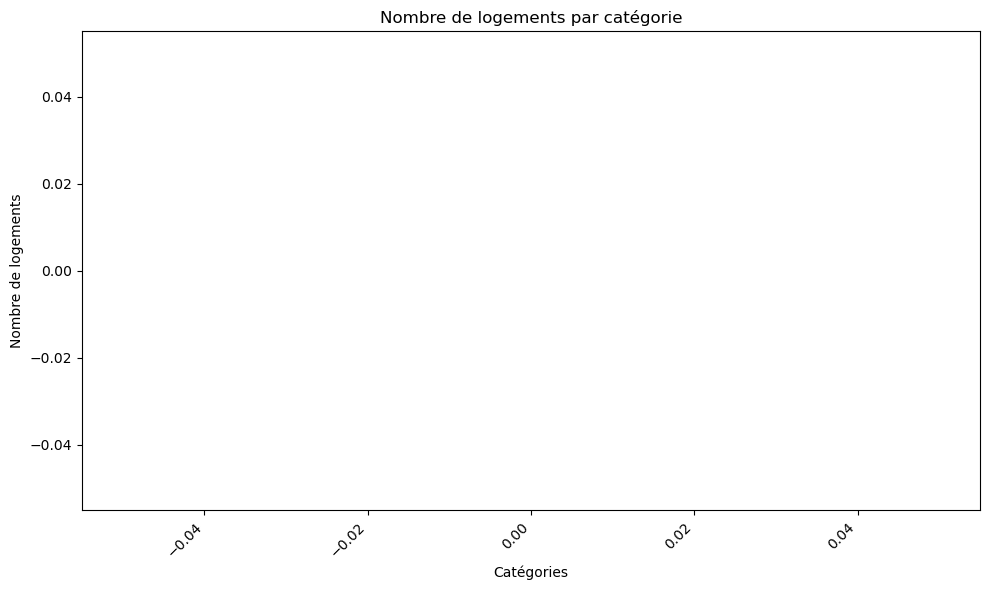

In [8]:
# Ajouter une colonne 'distance_from_center' si ce n'est pas déjà fait
reference_lat, reference_lon = 45.764043, 4.835659  # Coordonnées du centre de Lyon
listings['distance_from_center'] = listings.apply(
    lambda row: haversine(reference_lat, reference_lon, row['latitude'], row['longitude']), axis=1
)

# Catégorisation des logements
def categorize_listing(row):
    if row['distance_from_center'] <= 3:  # Rayon de 3 km pour définir le centre-ville
        location = 'Centre-ville'
    else:
        location = 'Périphérie'

    if 'Studio' in row['property_type']:
        category = 'Studio'
    elif row['accommodates'] >= 4 and row['bedrooms'] >= 2:
        category = 'Maison familiale'
    else:
        category = 'Autre'

    return f"{category} ({location})"

# Ajouter une colonne avec la catégorie
listings['profile_category'] = listings.apply(categorize_listing, axis=1)

# Filtrer les profils bien renseignés
listings_rich = listings.dropna(subset=['property_type', 'room_type', 'bedrooms', 'accommodates'])

# Regrouper par catégories pour caractériser les profils
profile_summary = listings_rich.groupby('profile_category').agg({
    'id': 'count',
    'price': ['mean', 'median'],
    'distance_from_center': 'mean'
}).reset_index()

# Renommer les colonnes
profile_summary.columns = ['Profile Category', 'Count', 'Avg Price', 'Median Price', 'Avg Distance from Center']

# Afficher le tableau dans un notebook
from IPython.display import display
display(profile_summary)

# Visualisation avec matplotlib
plt.figure(figsize=(10, 6))
plt.bar(profile_summary['Profile Category'], profile_summary['Count'], color='skyblue')
plt.title("Nombre de logements par catégorie")
plt.xlabel("Catégories")
plt.ylabel("Nombre de logements")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
import folium

# Créer une carte centrée à Lyon
m = folium.Map(location=[45.764043, 4.835659], zoom_start=12)

# Ajouter des marqueurs
for _, row in listings.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row['name']} ({row['distance_from_reference']:.2f} km)",
    ).add_to(m)

# Afficher la carte
m.save("map_airbnb.html")


#  Analyses exploratoires

## Corrélation entre prix et quartier :

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prix moyen par quartier
price_per_neighbourhood = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=price_per_neighbourhood.index, y=price_per_neighbourhood.values)
plt.title('Prix moyen par quartier')
plt.xticks(rotation=45)
plt.ylabel('Prix moyen ($)')
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

## Corrélation entre prix et quartier :